<a href="https://colab.research.google.com/github/pkhudov/cora-gnn-classifier/blob/main/GNN_Exercise_Pavel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise to develop familiarity with PyTorch Geometric and GNN training



The goal of this notebook is to develop first experience in training Graph Neural Networks using Pytorch Geometric, by performing node classification on a Cora dataset. It consists of a citation network of small size, where nodes represent documents, edges the citations, and embeddings some of the words used in the document. The task is to infer the category of each document, out of 7. It will be an instance of semi-supervised learning, more concretely transductive learning, where only some of the nodes are labelled, thus requiring us to classify the rest.

The exercise will focus on intuitively tuning the hyperparameters of GCN (Graph Convolutional Neural Network) and GAT (Graph Attention Neural Network). As there is potentially an unlimited amount of ways in which it can be done, the starting point is an already developed model from a [tutorial](https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX) on Pytorch Geometric and a paper by [Velickovic et al.](https://arxiv.org/pdf/1710.10903.pdf), for GCN and GAT respectively. Another reason for not starting from zero is that I read these resources before starting on each section, which means that anyway I would be unable to make unbiased decisions.

The more specific objective for each model tuning is outlined below in the corresponding model section.

## Setup

In [ ]:
# Install required packages.
import os
import torch

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(8,8))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

2.1.0+cu121
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Understanding the data


In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


## Helpers to train, evaluate and test

In [ ]:

def train(model, optimizer, criterion):
  model.train()
  optimizer.zero_grad() #Important! Otherwise, gradient accumulation.
  out = model(data.x, data.edge_index)
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  return loss

def eval(model):
  model.eval()
  out = model(data.x, data.edge_index)
  pred = out.argmax(dim=1)
  eval_correct = pred[data.val_mask] == data.y[data.val_mask]
  eval_acc = int(eval_correct.sum())/int(data.val_mask.sum())
  return eval_acc


def test(model):
  model.eval()
  out = model(data.x, data.edge_index)
  pred = out.argmax(dim=1)
  test_correct = (pred[data.test_mask] == data.y[data.test_mask])
  test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
  return test_acc


# GCN

The **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.

## Objective
 The objective of this subsection is to study the influence of different hyperparameters on the performance of a GCN model, and whether they can be tuned so that a resulting model achieves a higher accuracy than a model from this tutorial: [Node Classification.ipynb](https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX).


 We start by creating a custom class, allowing for flexibility in its structure:

In [ ]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
  def __init__(self, hidden_channels, num_layers, dropout_ratio=0.5):
    super().__init__()
    torch.manual_seed(1234567)
    self.convs = torch.nn.ModuleList()
    self.dropout_ratio = dropout_ratio

    self.convs.append(GCNConv(dataset.num_features, hidden_channels))

    for _ in range(num_layers-2):
      self.convs.append(GCNConv(hidden_channels, hidden_channels))

    self.convs.append(GCNConv(hidden_channels, dataset.num_classes))


  def forward(self, x, edge_index):

    for i, conv in enumerate(self.convs[:-1]):
      x = conv(x, edge_index)
      x = x.relu()
      x = F.dropout(x, p=self.dropout_ratio, training = self.training)

    x = self.convs[-1](x, edge_index)
    return x

## Model from a tutorial

The following model and training hyperparameters are used as a starting point for experimentation. The goal of the upcoming analysis is to see whether it can be improved. Firstly, we explore it:


In [ ]:
tutorial_model = GCN(hidden_channels=16, num_layers=2)
print(tutorial_model)

GCN(
  (convs): ModuleList(
    (0): GCNConv(1433, 16)
    (1): GCNConv(16, 7)
  )
)


We visualise the untrained model using TSNE, which projects 7 dimensional vector onto 2D. The colours represent actual classes, and we can see that datapoints are randomly scattered around, demonstrating a lack of structure in the output data at the moment.

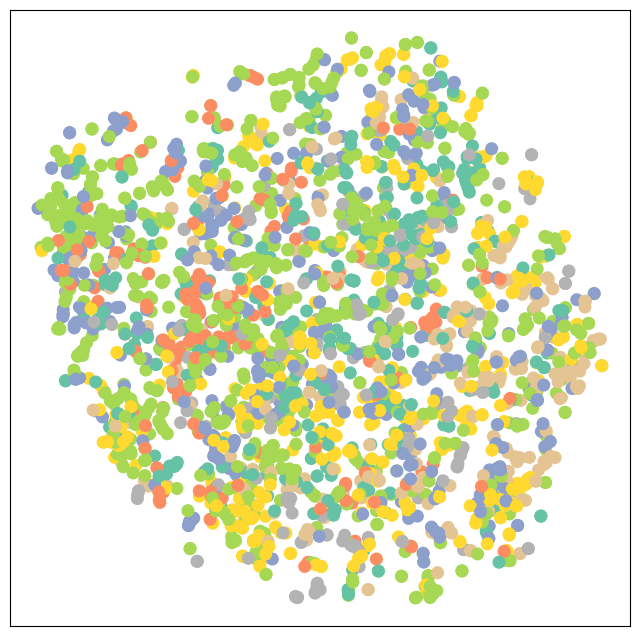

In [ ]:
tutorial_model.eval()
out = tutorial_model(data.x, data.edge_index)
visualize(out, color=data.y)

We now train the model:

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

optimizer = torch.optim.Adam(tutorial_model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 101):
  loss = train(tutorial_model, optimizer, criterion)
  print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9409
Epoch: 003, Loss: 1.9343
Epoch: 004, Loss: 1.9275
Epoch: 005, Loss: 1.9181
Epoch: 006, Loss: 1.9086
Epoch: 007, Loss: 1.9015
Epoch: 008, Loss: 1.8933
Epoch: 009, Loss: 1.8808
Epoch: 010, Loss: 1.8685
Epoch: 011, Loss: 1.8598
Epoch: 012, Loss: 1.8482
Epoch: 013, Loss: 1.8290
Epoch: 014, Loss: 1.8233
Epoch: 015, Loss: 1.8057
Epoch: 016, Loss: 1.7966
Epoch: 017, Loss: 1.7825
Epoch: 018, Loss: 1.7617
Epoch: 019, Loss: 1.7491
Epoch: 020, Loss: 1.7310
Epoch: 021, Loss: 1.7147
Epoch: 022, Loss: 1.7056
Epoch: 023, Loss: 1.6954
Epoch: 024, Loss: 1.6697
Epoch: 025, Loss: 1.6538
Epoch: 026, Loss: 1.6312
Epoch: 027, Loss: 1.6161
Epoch: 028, Loss: 1.5899
Epoch: 029, Loss: 1.5711
Epoch: 030, Loss: 1.5576
Epoch: 031, Loss: 1.5393
Epoch: 032, Loss: 1.5137
Epoch: 033, Loss: 1.4948
Epoch: 034, Loss: 1.4913
Epoch: 035, Loss: 1.4698
Epoch: 036, Loss: 1.3998
Epoch: 037, Loss: 1.4041
Epoch: 038, Loss: 1.3761
Epoch: 039, Loss: 1.3631
Epoch: 040, Loss: 1.3258


Evaluate it and visualize. We can see that now documents of the same class are clustered together:

Evaluation Accuracy: 0.7780 


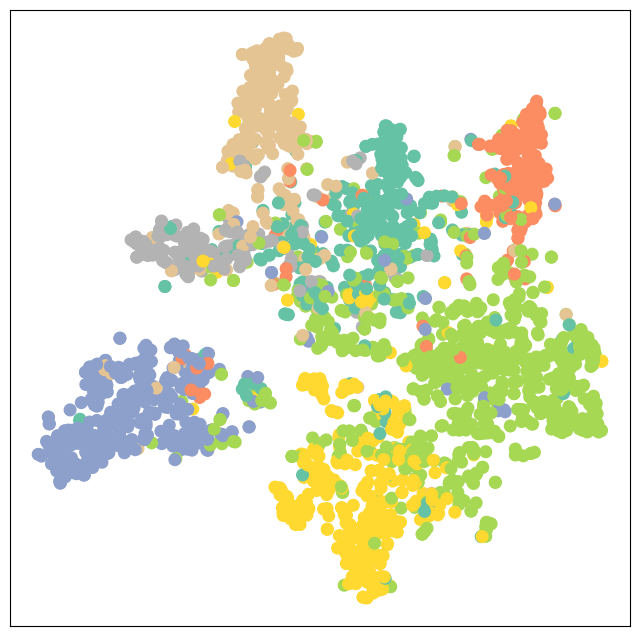

In [ ]:
eval_acc_tutorial = eval(tutorial_model)
print(f"Evaluation Accuracy: {eval_acc_tutorial:.4f} ")

tutorial_model.eval()
out = tutorial_model(data.x, data.edge_index)
visualize(out, color=data.y)

## Experimenting with model hyperparameters
In this section we will be tuning the parameters of the model that have to do with its structure, and observe the results.

### Number of layers
We add more layers to the model. Other parameters are kept unchanged.

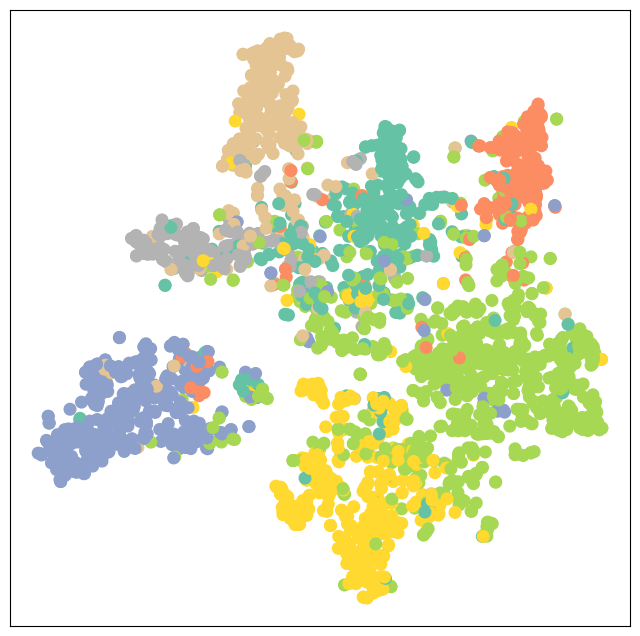

Number of layers: 002; Evaluation Accuracy: 0.7780



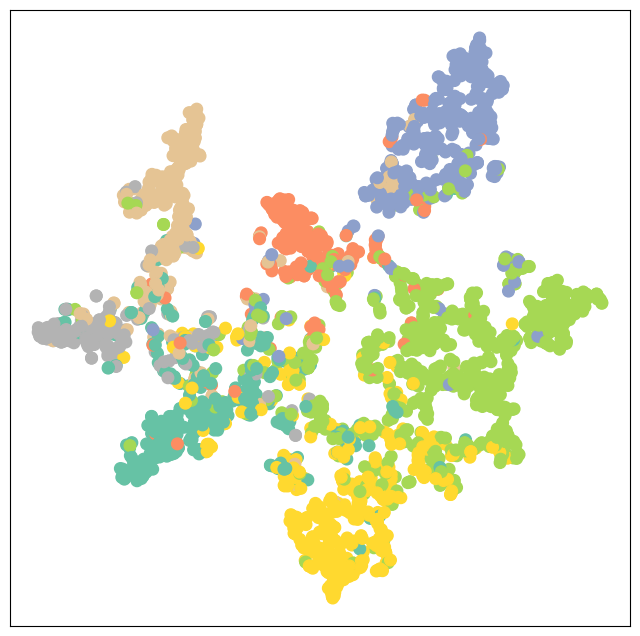

Number of layers: 003; Evaluation Accuracy: 0.7640



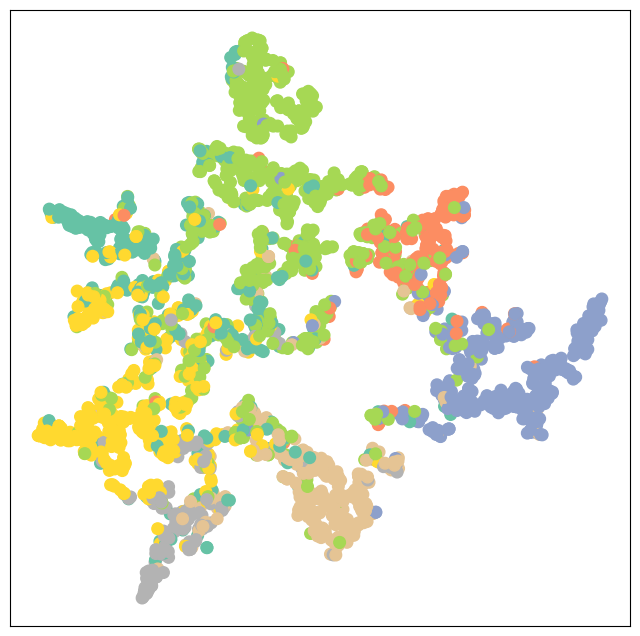

Number of layers: 004; Evaluation Accuracy: 0.6700



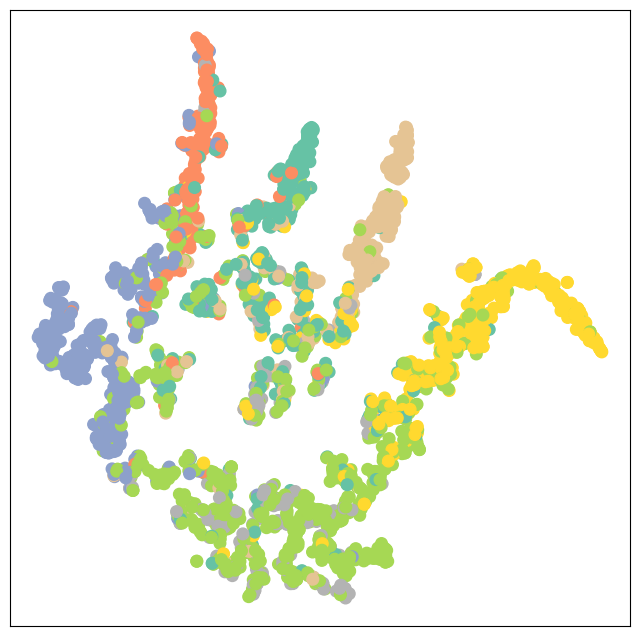

Number of layers: 005; Evaluation Accuracy: 0.6120



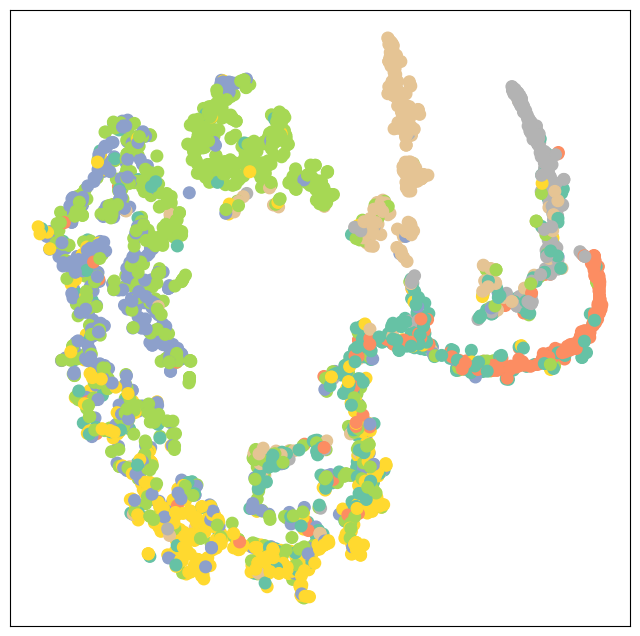

Number of layers: 006; Evaluation Accuracy: 0.4960



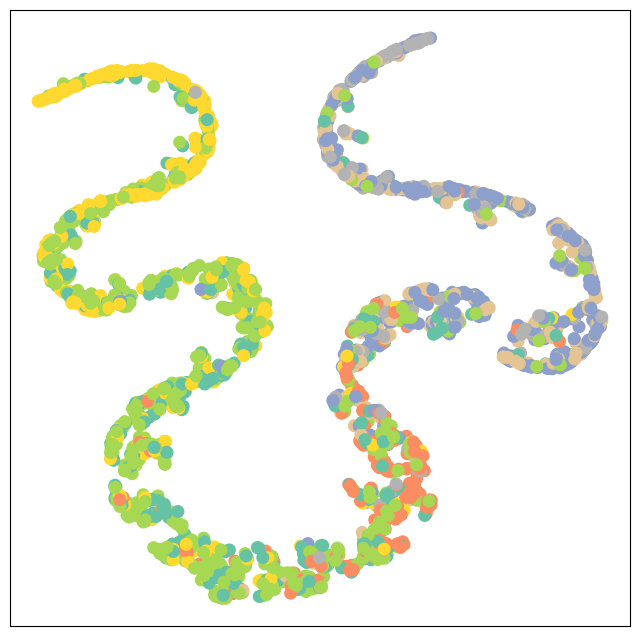

Number of layers: 007; Evaluation Accuracy: 0.4480



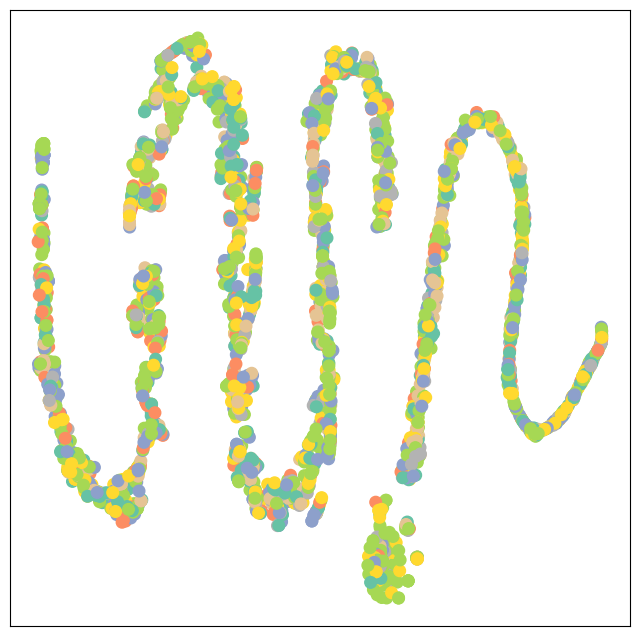

Number of layers: 008; Evaluation Accuracy: 0.1660



In [ ]:
max_num_layers = 8


for n in range(2, max_num_layers+1):
  model = GCN(hidden_channels=16, num_layers=n)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
  criterion = torch.nn.CrossEntropyLoss()

  for epoch in range(1, 101):
    loss = train(model, optimizer, criterion)

  model.eval()
  out = model(data.x, data.edge_index)
  visualize(out, color=data.y)

  eval_acc = eval(model)
  print(f"Number of layers: {n:03d}; Evaluation Accuracy: {eval_acc:.4f}\n")



If too many layers are used, a fenomena called 'oversmoothing' occurs. It can be observed that the features are aggregated so much that the nodes' features become indistinguishable from each other. It is indicated by their alignment on the plot. Hence, 2 layers is optimal for this use case.

### Hidden features dimensionality
We experiment with the number of hidden channels, doubling them with each test. A depth of 2 layers is maintained for consistency.

In [ ]:

for i in range(0, 12):
  n = 2**i #From 1 to 2048
  model = GCN(hidden_channels=n, num_layers=2)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
  criterion = torch.nn.CrossEntropyLoss()

  for epoch in range(1, 101):
    loss = train(model, optimizer, criterion)

  #Calculate accuracy of model on training data
  out = model(data.x, data.edge_index)
  pred = out.argmax(dim=1)
  train_correct = pred[data.train_mask] == data.y[data.train_mask]
  train_acc = int(train_correct.sum())/int(data.train_mask.sum())

  #Now on evaluation data
  eval_acc = eval(model)

  print(f"Number of hidden channels: {n:03d}; Training Accuracy: {train_acc:.4f}; Evaluation Accuracy: {eval_acc:.4f}")



Number of hidden channels: 001; Training Accuracy: 0.2500; Evaluation Accuracy: 0.2520
Number of hidden channels: 002; Training Accuracy: 0.2714; Evaluation Accuracy: 0.2800
Number of hidden channels: 004; Training Accuracy: 0.6929; Evaluation Accuracy: 0.6920
Number of hidden channels: 008; Training Accuracy: 0.9000; Evaluation Accuracy: 0.7500
Number of hidden channels: 016; Training Accuracy: 0.9357; Evaluation Accuracy: 0.7780
Number of hidden channels: 032; Training Accuracy: 0.9857; Evaluation Accuracy: 0.7800
Number of hidden channels: 064; Training Accuracy: 0.9929; Evaluation Accuracy: 0.7960
Number of hidden channels: 128; Training Accuracy: 1.0000; Evaluation Accuracy: 0.7960
Number of hidden channels: 256; Training Accuracy: 1.0000; Evaluation Accuracy: 0.8000
Number of hidden channels: 512; Training Accuracy: 1.0000; Evaluation Accuracy: 0.7920
Number of hidden channels: 1024; Training Accuracy: 1.0000; Evaluation Accuracy: 0.8020
Number of hidden channels: 2048; Training 

The first thing we notice is that the number of hidden channels influences a lot the training time of the model, so choosing high number of them is undesirable. We observe that there is an improvement in accuracy of 0.018 when going from 16 channels to 64, while still not heavily overfitting training data. That will be the first modification to the model.

Suprisingly, only later, after moving on to implementing GAT, in [this](https://arxiv.org/pdf/1710.10903.pdf) paper about them I found out that 64 is indeed the number of layers that achieves the best performance for GCN (Indicated in Table 2 in the paper).

### Activation Function
We create another GCN classes but with different activation functions, sigmoid and tanh, and see whether they improve the performance.

In [ ]:
class GCN_sigmoid(torch.nn.Module):
  def __init__(self, hidden_channels, num_layers, dropout_ratio=0.5):
    super().__init__()
    torch.manual_seed(1234567)
    self.convs = torch.nn.ModuleList()
    self.dropout_ratio = dropout_ratio

    self.convs.append(GCNConv(dataset.num_features, hidden_channels))

    for _ in range(num_layers-2):
      self.convs.append(GCNConv(hidden_channels, hidden_channels))

    self.convs.append(GCNConv(hidden_channels, dataset.num_classes))


  def forward(self, x, edge_index):

    for i, conv in enumerate(self.convs[:-1]):
      x = conv(x, edge_index)
      x = torch.sigmoid(x)
      x = F.dropout(x, p=self.dropout_ratio, training = self.training)

    x = self.convs[-1](x, edge_index)
    return x

class GCN_tanh(torch.nn.Module):
  def __init__(self, hidden_channels, num_layers, dropout_ratio=0.5):
    super().__init__()
    torch.manual_seed(1234567)
    self.convs = torch.nn.ModuleList()
    self.dropout_ratio = dropout_ratio

    self.convs.append(GCNConv(dataset.num_features, hidden_channels))

    for _ in range(num_layers-2):
      self.convs.append(GCNConv(hidden_channels, hidden_channels))

    self.convs.append(GCNConv(hidden_channels, dataset.num_classes))


  def forward(self, x, edge_index):

    for i, conv in enumerate(self.convs[:-1]):
      x = conv(x, edge_index)
      x = torch.tanh(x)
      x = F.dropout(x, p=self.dropout_ratio, training = self.training)

    x = self.convs[-1](x, edge_index)
    return x


criterion = torch.nn.CrossEntropyLoss()
#Train and eval sigmoid
model_sigmoid = GCN_sigmoid(16, 2)
optimizer_sigmoid = torch.optim.Adam(model_sigmoid.parameters(), lr=0.01, weight_decay=5e-4)

for epoch in range(1, 101):
  train(model_sigmoid, optimizer_sigmoid, criterion)

eval_sigmoid = eval(model_sigmoid)

#Train and eval tanh
model_tanh = GCN_tanh(16, 2)
optimizer_tanh = torch.optim.Adam(model_tanh.parameters(), lr=0.01, weight_decay=5e-4)

for epoch in range(1, 101):
  train(model_tanh, optimizer_tanh, criterion)

eval_tanh = eval(model_tanh)

print(f'ReLU activation; Evaluation Accuracy: {eval_acc_tutorial}')
print(f'Sigmoid activation; Evaluation Accuracy: {eval_sigmoid}')
print(f'Tanh Activation; Evaluation Accuracy: {eval_tanh}')



ReLU activation; Evaluation Accuracy: 0.778
Sigmoid activation; Evaluation Accuracy: 0.292
Tanh Activation; Evaluation Accuracy: 0.776


We remain with ReLU

## Experimenting with the training hyperparameters
In this section we move to experimenting with parameters that influence the training process:

### Dropout rate
We try eliminating different proportion of neurons in a layer at each experiment. It is a regularization technique that allows to deal with overfitting. The number of epochs is increased to 400 make it more prone to overfitting, allowing for its easier observation. For visualisation we use learning curves that show the losses with each epoch.

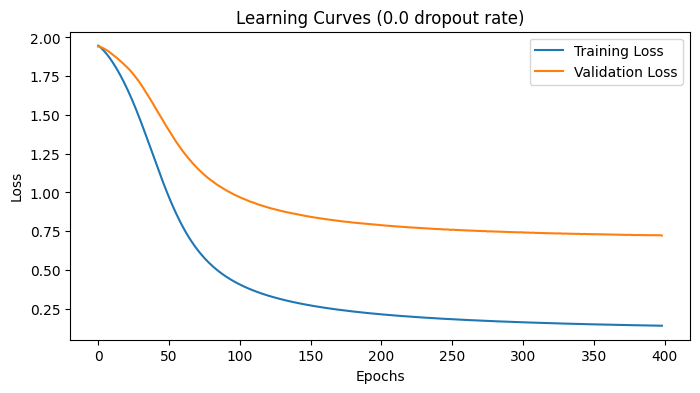

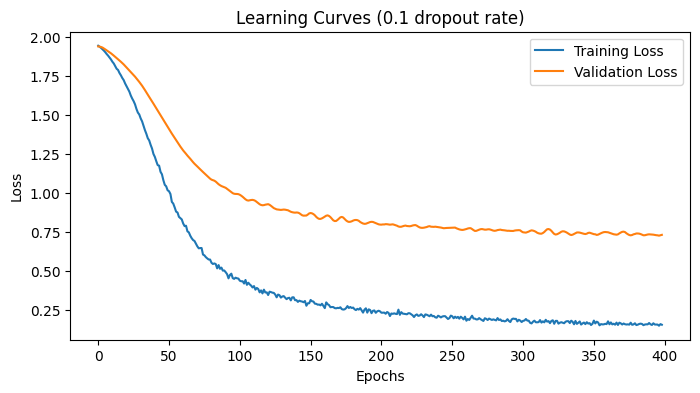

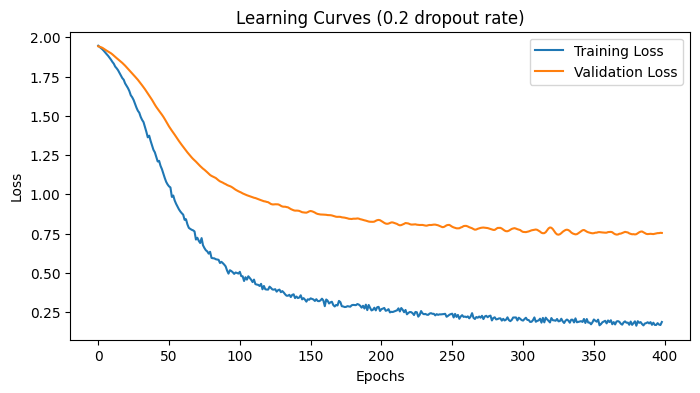

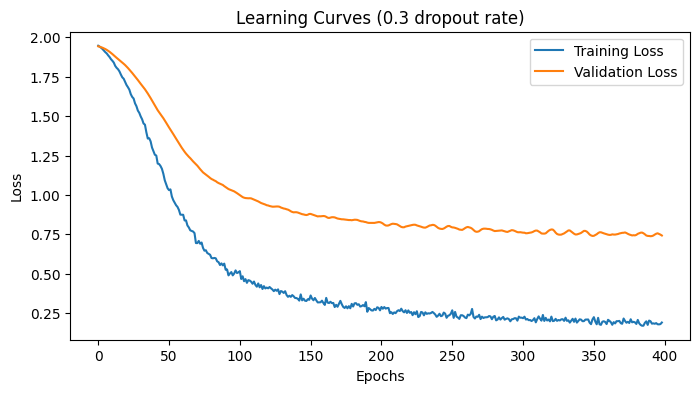

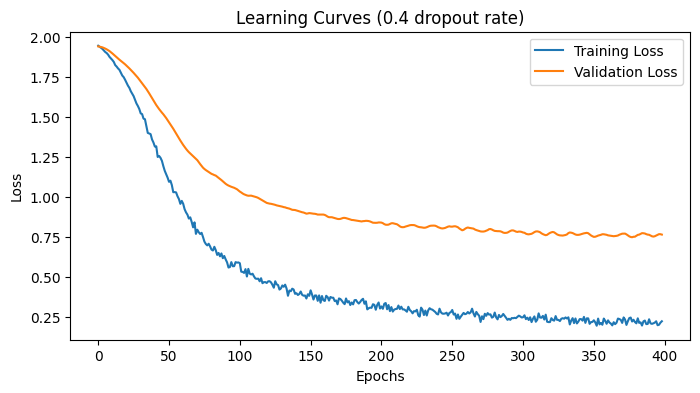

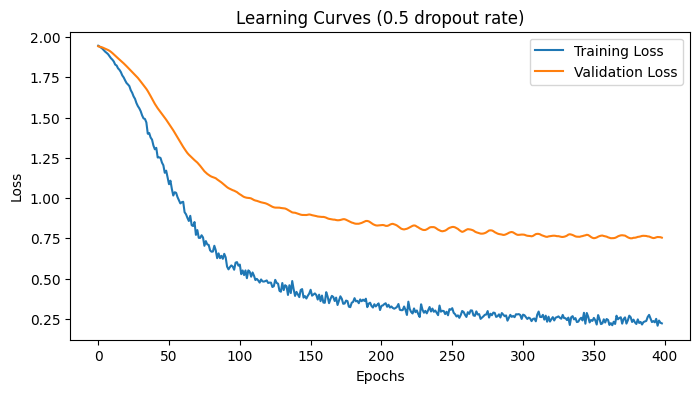

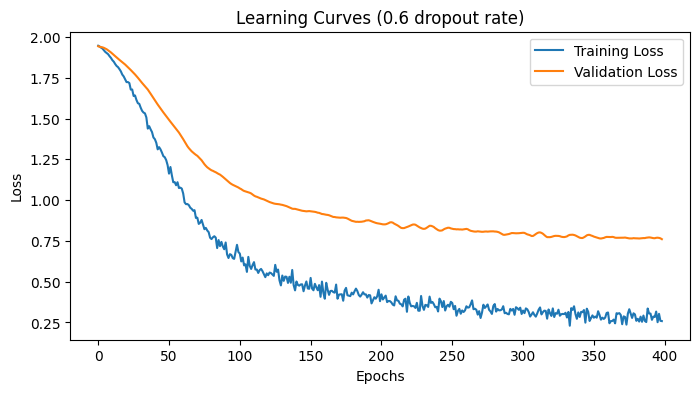

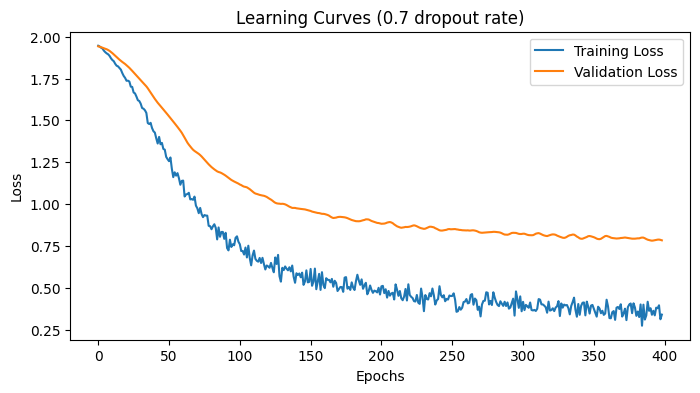

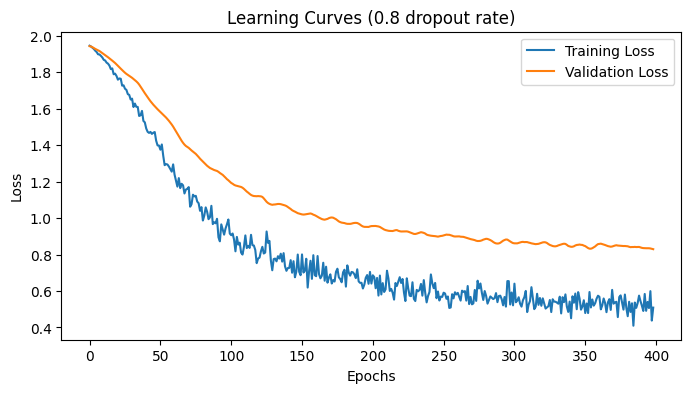

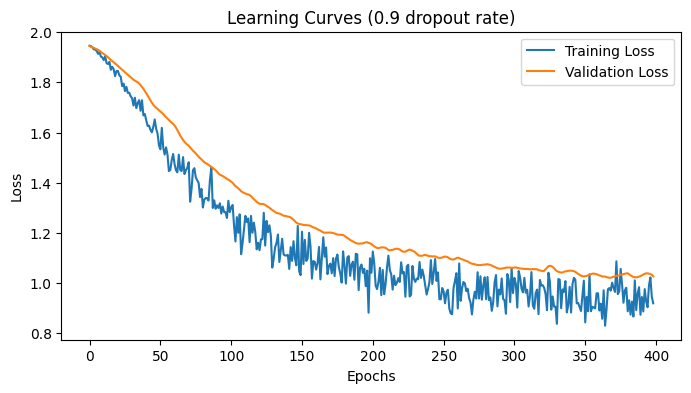

In [ ]:

def plot_learning_curves(training_losses, validation_losses, dropout):
    plt.figure(figsize=(8, 4))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Learning Curves ({dropout} dropout rate)')
    plt.legend()
    plt.show()

for i in range(0, 10):
  dropout = i/10 #In steps of 0.1

  model = GCN(hidden_channels=16, num_layers=2, dropout_ratio=dropout)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
  criterion = torch.nn.CrossEntropyLoss()

  training_losses = []
  validation_losses = []

  for epoch in range(1, 400):
    training_loss = train(model, optimizer, criterion)
    training_losses.append(training_loss.item())

    model.eval()
    out = model(data.x, data.edge_index)
    validation_loss = criterion(out[data.val_mask], data.y[data.val_mask])
    validation_losses.append(validation_loss.item())

  plot_learning_curves(training_losses, validation_losses, dropout)






At no point it can be observed that the losses of training and validation set deviate from each other, indicating that the model is not prone to overfitting. That means that lower dropout rates are more appropriate. Hence it can be modified from 0.5 to ~0.3. Even though it can be seen that at high dropout rate training loss and validation loss are closer to each other, it comes at the expense of being very noisy.

### Number of epochs
From the previous plots, it can be seen that a graph's knee is around a 100, so the previously used 100 epochs are appropriate.

### Weight decay
We experiment with another regularization technique, which penalizes large weights. Number of epochs are increased to make it more prone to overfitting.

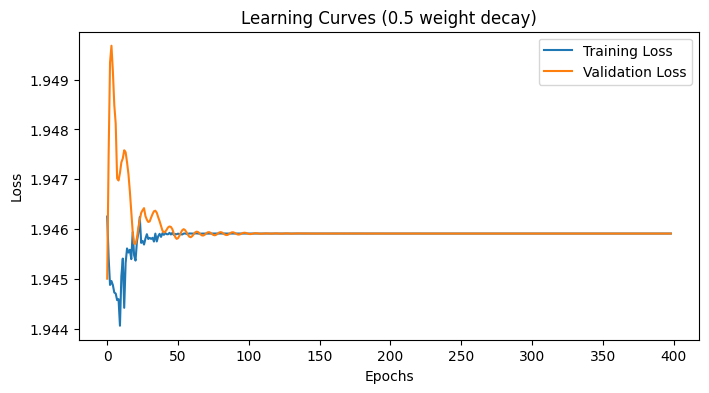

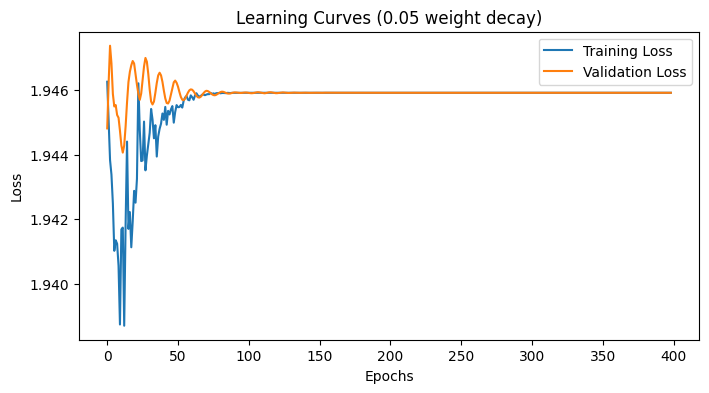

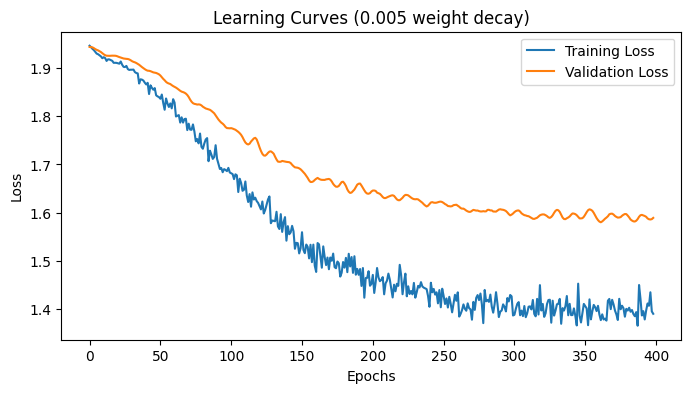

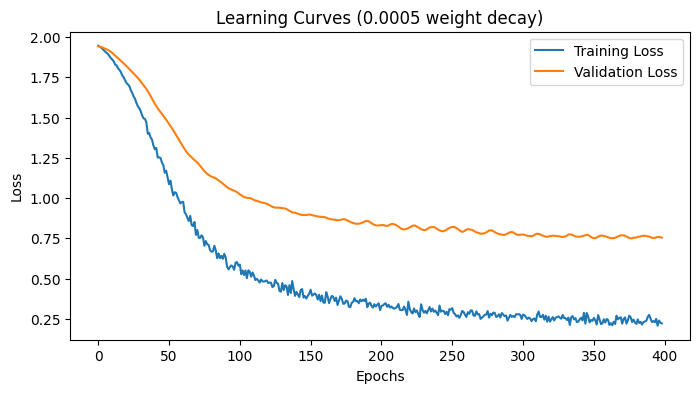

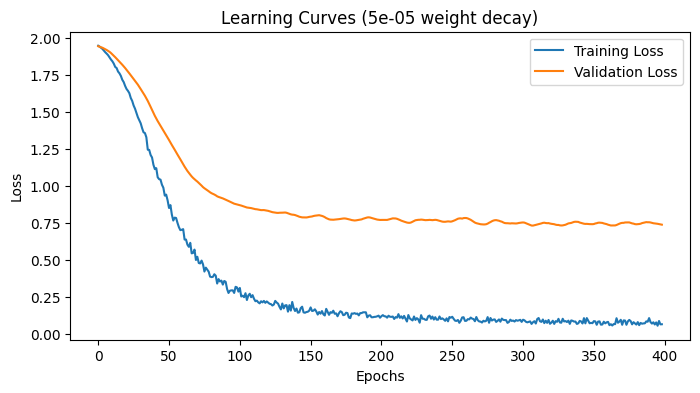

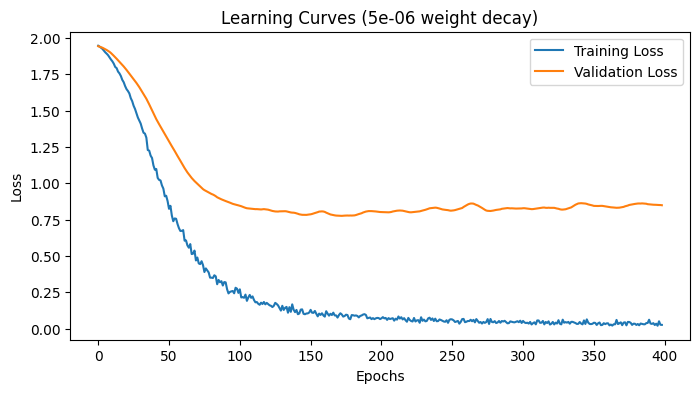

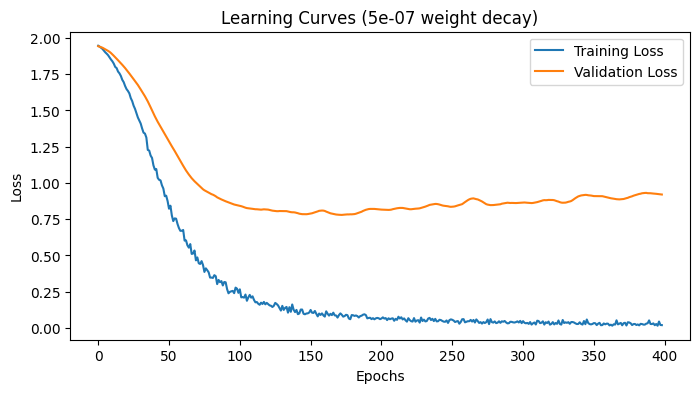

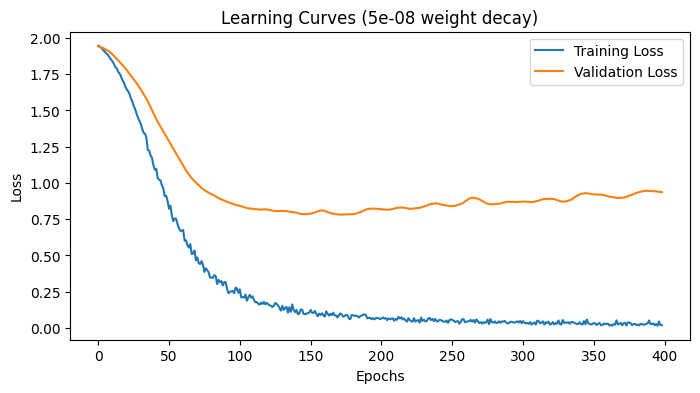

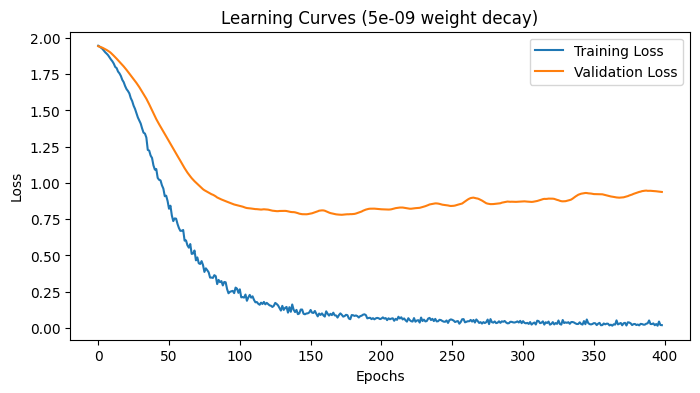

In [ ]:
def plot_learning_curves(training_losses, validation_losses, decay):
    plt.figure(figsize=(8, 4))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Learning Curves ({decay} weight decay)')
    plt.legend()
    plt.show()

for i in range(1, 10):
  weight_decay = 5/(10**i) #Reduce by a factor of 10 with each iteration

  model = GCN(hidden_channels=16, num_layers=2)

  optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=weight_decay)
  criterion = torch.nn.CrossEntropyLoss()

  training_losses = []
  validation_losses = []

  for epoch in range(1, 400):
    training_loss = train(model, optimizer, criterion)
    training_losses.append(training_loss.item())

    model.eval()
    out = model(data.x, data.edge_index)
    validation_loss = criterion(out[data.val_mask], data.y[data.val_mask])
    validation_losses.append(validation_loss.item())

  plot_learning_curves(training_losses, validation_losses, weight_decay)

It can be seen that the appropriate value for weight decay is in the order of 10^-4, as lower values demonstrate an increase in validation loss and decrease in training loss, indicating overfitting.

## Testing
Considering the above analysis, it can be concluded that, out of the explored options, the following hyperparameters could be used to achieve optimal performance of GCN for the node classification task of the Cora dataset:

*   Number of layers: 2
*   Number of hidden channels: 64
*   Activation function: ReLU
*   Number of Epochs: 100
*   Dropout Rate: 0.3
*   Weight decay: 5e-4

We perform final evaluation on evaluation and testing dataset, comparing it to that of the tutorial model:

In [ ]:
#Create custom model
custom_model = GCN(hidden_channels=64, num_layers=2, dropout_ratio=0.3)
optimizer = torch.optim.Adam(custom_model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 101):
  train(custom_model, optimizer, criterion)

custom_eval_acc = eval(custom_model)
custom_test_acc = test(custom_model)

#Replicate tutorial model
tutorial_model = GCN(hidden_channels=16, num_layers=2, dropout_ratio=0.5)
optimizer = torch.optim.Adam(tutorial_model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 101):
  train(tutorial_model, optimizer, criterion)

tutorial_eval_acc = eval(tutorial_model)
tutorial_test_acc = test(tutorial_model)

#Print results
print(f'Custom Model:   Evaluation accuracy: {custom_eval_acc: .4f}; Test accuracy: {custom_test_acc:.4f}')
print(f'Tutorial Model: Evaluation accuracy: {tutorial_eval_acc: .4f}; Test accuracy: {tutorial_test_acc:.4f}')




Custom Model:   Evaluation accuracy:  0.8000; Test accuracy: 0.8080
Tutorial Model: Evaluation accuracy:  0.7780; Test accuracy: 0.8150


## Conclusion
We see that evaluation accuracy is 2.2% higher than that of the tutorial model (77.80%). However, on the final test with testing data, the tutorial model shows better performance by 0.7%. At first that may indicate that we overfitted our model to the **evaluation** data. On the other hand, we do not know how the tutorial model was tuned in itself, so it could be overfitted to the **testing** data. Thus we cannot conclude which one of the two has better performance, and we can not guarantee that our model is more accurate than the tutorial's.


To reach clear conclusions, further work would require a more quantitative approach. Additionaly, it would have to take into account that the performance of the model can be judged on other metrics, like precision, recall, ROC Curve and AUC etc. Also, further study on influence of hyperparameters can be performed, which would include experimenting with different optimizers, learning rates, different amount of dropout layers, and using Linear classifier instead of last GNN layer.




# GAT

## Objective
The goal is to explore the influence of characteristic hyperparameters of Graph Attention Neural Networks, more specifically the number of attention heads and whether to perform concatenation, and we will compare it to the performance of the previous GCN. We will not focus on other hyperparamters as they were explored in the previous section, so we set them as indicated in the experimental setup [in the GAT paper](https://arxiv.org/pdf/1710.10903.pdf).

In [ ]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
  def __init__(self, hidden_channels, heads_first_layer, concat1, heads_second_layer):
    super().__init__()
    torch.manual_seed(1234567)
    self.conv1 = GATConv(dataset.num_features, hidden_channels, heads=heads_first_layer, concat=concat1)
    self.conv2 = GATConv((hidden_channels*heads_first_layer if concat1==True else hidden_channels), dataset.num_classes, heads=heads_second_layer, concat=False)

  def forward(self, x, edge_index):
    x = F.dropout(x, p=0.6, training=self.training)
    x = self.conv1(x, edge_index)
    F.elu(x)
    x = F.dropout(x, p=0.6, training=self.training)
    x = self.conv2(x, edge_index)
    return x


## Concatenation
As it is important to match the output dimensionality to the number of classes, we do not concatenate last layer. However, we evaluate the influence of concatenation on the first layer of our model. We set the number of attention heads as described in the paper, 8 for the first layer and 1 for the last.

In [ ]:
model_concat = GAT(8, 8, True, 1)
optimizer = torch.optim.Adam(model_concat.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 101):
  train(model_concat, optimizer, criterion)

eval_concat = eval(model_concat)


model_not_concat = GAT(8, 8, False, 1)
optimizer = torch.optim.Adam(model_not_concat.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 101):
  train(model_not_concat, optimizer, criterion)

eval_not_concat = eval(model_concat)

print(f'Concatenation: Yes; Evaluation Accuracy: {eval_concat:.4f}')
print(f'Concatenation:  No; Evaluation Accuracy: {eval_not_concat:.4f}')

Concatenation: Yes; Evaluation Accuracy: 0.7860
Concatenation:  No; Evaluation Accuracy: 0.7860


We see that in this use case it makes no difference. However according to standard practice, and how it is described in the paper, it is recommended to set concatenation to true to allow for greater feature representation capacity.

## Number of heads
We experiment with the number of heads in the first layer, maintaining concatenation.

In [ ]:
for i in range(0, 7):
  heads = 2**i
  model = GAT(hidden_channels=8, heads_first_layer=heads, concat1=True, heads_second_layer=1)

  optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
  criterion = torch.nn.CrossEntropyLoss()

  for epoch in range(1, 101):
    train(model, optimizer, criterion)

  eval_acc = eval(model)
  print(f'Number of heads in the first layer: {heads:03d}; Evaluation Accuracy: {eval_acc:.4f}')


Number of heads in the first layer: 001; Evaluation Accuracy: 0.7260
Number of heads in the first layer: 002; Evaluation Accuracy: 0.7820
Number of heads in the first layer: 004; Evaluation Accuracy: 0.7760
Number of heads in the first layer: 008; Evaluation Accuracy: 0.7860
Number of heads in the first layer: 016; Evaluation Accuracy: 0.7600
Number of heads in the first layer: 032; Evaluation Accuracy: 0.7800
Number of heads in the first layer: 064; Evaluation Accuracy: 0.8120


Increasing number of heads leads to higher computational complexity, so around 8 is an adequate number.

We perform the same experiment, but modifying number of attention heads in the last layer. It is not a standard practice as the goal is to reduce the complexity to produce final class scores:

In [ ]:
for i in range(0, 7):
  heads = 2**i
  model = GAT(hidden_channels=8, heads_first_layer=8, concat1=True, heads_second_layer=heads)

  optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
  criterion = torch.nn.CrossEntropyLoss()

  for epoch in range(1, 101):
    train(model, optimizer, criterion)

  eval_acc = eval(model)
  print(f'Number of heads in the second layer: {heads:03d}; Evaluation Accuracy: {eval_acc:.4f}')


Number of heads in the second layer: 001; Evaluation Accuracy: 0.7860
Number of heads in the second layer: 002; Evaluation Accuracy: 0.7920
Number of heads in the second layer: 004; Evaluation Accuracy: 0.8020
Number of heads in the second layer: 008; Evaluation Accuracy: 0.8080
Number of heads in the second layer: 016; Evaluation Accuracy: 0.7960
Number of heads in the second layer: 032; Evaluation Accuracy: 0.7980
Number of heads in the second layer: 064; Evaluation Accuracy: 0.6840


Nevertheless we see that increasing them to 8 improves evaluation accuracy. Using the testing set, we can check whether there is an increase in accuracy compared to the model with one attention head as described in the paper. We also compare the result to our previous GCN.

In [ ]:
#Model with 8 heads on final layer
model_8_final_heads = GAT(hidden_channels=8, heads_first_layer=8, concat1=True, heads_second_layer=8)
optimizer = torch.optim.Adam(model_8_final_heads.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 101):
  train(model_8_final_heads, optimizer, criterion)

test_8_final_heads = test(model_8_final_heads)
print(f'Number of heads in the second layer: 8; Test Accuracy: {test_8_final_heads:.4f}')

#Model with 1 head on final layer, as described in the paper
model_1_final_head = GAT(hidden_channels=8, heads_first_layer=8, concat1=True, heads_second_layer=1)
optimizer = torch.optim.Adam(model_1_final_head.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 101):
  train(model_1_final_head, optimizer, criterion)

test_1_final_head = test(model_1_final_head)
print(f'Number of heads in the second layer: 1; Test Accuracy: {test_1_final_head:.4f}')

#GCN result
print(f'GCN-64 previous result; Test Accuracy: 0.8080')

Number of heads in the second layer: 8; Test Accuracy: 0.8120
Number of heads in the second layer: 1; Test Accuracy: 0.8070
GCN-64 previous result; Test Accuracy: 0.8080


## Conclusion

We were not able to replicate the results of the paper on GAT by Velickovic et al. where they estimated the accuracy of the model to be 83%. We achieved 80.7%, which is even worse than the previously implemented GCN. Nevertheless, we achieved an increase of 0.4% in accuracy over the GCN by setting number of heads in second layer to 8. Furthermore, we observed that the number of heads has greater infuence on final result than the choice of concatenation of features, as expected.